In [1]:
# Computational Physics Project 4 - Molecular Orbital Theory
# Ben Zager, Zach Faber-Manning, Michael Rosen

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.linalg import eigh,solve,norm

np.set_printoptions(precision=3)


In [79]:
# Define molecules

buta = {"name":"butadiene","db":2}
benz = {"name":"benzene","db":3}
tolu = {"name":"toluene","db":3} # benzene with methyl group
naph = {"name":"naphthalene","db":5} # two connected benzene rings
buck = {"name":"buckyball","db":30} # Buckminsterfullerene
ethe = {"name":"ethene","db":1}

In [88]:
# Set molecule to analyze

mol = buck # select molecule

name = mol["name"]
adj = np.loadtxt("data/"+name+".txt")

N = adj.shape[0] # number of carbons
Ne = N # number of pi electrons
db = mol["db"] # number of double bonds (2 for butadiene, 3 for benzene/toluene, 5 for naphthalene, 30 for buckyball)

In [89]:
# Compute eigenvalues and eigenvectors
# analytical solutions, molecule with n atoms
# linear molecule: E_k = 2cos(k*pi/(n+1))
# cyclic molecule: E_k = 2cos(2k*pi/n)

# gram schmidt method to orthonormalize eigenvectors
# M is a matrix with each column an eigenvector, V is new matrix
# adapted from andreask.cs.illinois.edu/cs357-s15/public/demos/05-orthgonality/Gram-Schmidt%20and%20Modified%20Gram-Schmidt.py
def gramSchmidt(M):
    n = M.shape[0]
    V = np.zeros([n,n])
    V[:,0] = M[:,0] / norm(M[:,0])

    for i in range(n):
        q = M[:,i]
        for j in range(i):
            q = q - np.dot(q,V[:,j])*V[:,j]
    
        V[:,i] = q/norm(q)
        
    return V
    
# Finds eigenvalues and eigenvectors
# args: adjacency matrix
# rets: tuple, (eigenvalues,eigenvectors) 
def getEigs(adj):
    eigs = eigh(adj)
    evals = np.flip(np.around(eigs[0],4),0) # eigenvalues
    evecs = np.flip(np.around(eigs[1],4),1) # eigenvectors
    
    evecs = gramSchmidt(evecs) # orthogonalize eigenvectors
    
    return (evals,evecs)

evals,evecs = getEigs(adj)

print("Eigenvalues\n")
for i in range(N):
    print(str(i+1)+" : a + "+str(np.around(evals[i],3))+"b  " + str(np.around(evecs[:,i],3)))


Eigenvalues

1 : a + 3.0b  [-0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129
 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129
 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129
 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129
 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129
 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129 -0.129]
2 : a + 2.757b  [ 0.     0.064  0.03  -0.055 -0.074  0.01  -0.056 -0.024  0.062  0.083
  0.147  0.156  0.2    0.218  0.186  0.074  0.147  0.145  0.071  0.027
 -0.109 -0.07  -0.112 -0.176 -0.174 -0.149 -0.196 -0.216 -0.182 -0.14   0.14
  0.182  0.216  0.196  0.149  0.174  0.176  0.112  0.07   0.109 -0.027
 -0.071 -0.145 -0.147 -0.074 -0.186 -0.218 -0.2   -0.156 -0.147 -0.083
 -0.062  0.024  0.056 -0.01   0.074  0.055 -0.03  -0.064  0.   ]
3 : a + 2.757b  [ 0.223  0.209  0.185  0.185  0.209  0.198  0.161  0.102  0.102  0.162
  0.168  0.145  0

In [114]:
# Very ugly function, try to improve

# Plots energy level diagram and determines electron energies
# args: ordered list of eigenvalues, number of electrons
# rets: list of energies for the Ne electrons
def energyLevel(evals,Ne,name,show=False,save=False):
    
    # parameters for drawing diagram
    mid = 0.5 # midpoint
    width = 0.05 # width of each line
    space = 0.015 # spacing between lines
    arrlen = 0.15 # arrow length
    hw = 0.01 # width of head of arrow
    hl = 0.1 # length of head of arrow

    # get unique list of energies
    # returns tuple of two arrays, ([energies],[multiplicity])
    uniq = np.unique(np.around(evals,4),return_counts=True)

    energies = np.zeros(Ne) # stores energies of each electron
    occu = np.zeros(evals.size) # occupation number
    filled = 0 # keep track of how many electrons are left
    orb = 1 # keep track of current orbital
    
    for i in range(uniq[0].size): # go through each unique energy level
        E = uniq[0][i]
        m = uniq[1][i] # multiplicity
        start = mid - 0.5*(m-1)*(width+space) # where first line is drawn (left edge)
        
        turn = 1 # 1st or 2nd sweep through level
        j = 0 # keep track of degenerate energy levels

        while j < m:
            xL = start + j*(width+space) - 0.5*width # set bounds for drawing line
            xR = xL + width
            plt.axhline(E,xmin=xL,xmax=xR) # draw horizontal line
            if filled < Ne:
                energies[filled] = E
                if turn == 1:
                    elec = np.mean([xL,xR]) - 0.25*width
                    plt.arrow(elec,E,0,arrlen,head_width=hw,head_length=hl,fc='k',ec='k')
                    filled += 1
                    occu[orb-1] = 1
                    if j == m-1:
                        turn = 2
                        j = 0
                        orb -= (m-1)
                        continue     
                elif turn == 2:
                    elec = np.mean([xL,xR]) + 0.25*width
                    plt.arrow(elec,E+arrlen+hl,0,-arrlen,head_width=hw,head_length=hl,fc='k',ec='k')
                    filled += 1
                    occu[orb-1] = 2
                orb += 1
            j += 1
    
    plt.ylabel("Energy")
    plt.xlim([0,1])
    plt.ylim([np.min(evals),np.max(evals)+2*hl])
    plt.title("Energy Level Diagram for "+name)
    if save:
        plt.savefig("figures/energyLevels_"+name+".png")
    elif show:
        plt.show()
        
    return energies,occu

energies,occu = energyLevel(evals,Ne,name,show=True,save=True)
ETot = np.sum(energies)
print("Electron energies:",energies)
print("Occupation numbers:",occu)
print("Total ground state energy:",str(ETot)+"b")


Electron energies: [-2.618 -2.618 -2.618 -2.618 -2.618 -2.618 -2.562 -2.562 -2.562 -2.562
 -2.562 -2.562 -2.562 -2.562 -2.    -2.    -2.    -2.    -2.    -2.    -2.
 -2.    -1.618 -1.618 -1.618 -1.618 -1.618 -1.618 -1.618 -1.618 -1.618
 -1.618 -1.438 -1.438 -1.438 -1.438 -1.438 -1.438 -1.303 -1.303 -1.303
 -1.303 -1.303 -1.303 -1.303 -1.303 -1.303 -1.303 -0.382 -0.382 -0.382
 -0.382 -0.382 -0.382 -0.139 -0.139 -0.139 -0.139 -0.139 -0.139  0.618
  0.618  0.618  0.618  0.618  0.618  0.618  0.618  0.618  0.618  1.     1.
  1.     1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
  1.     1.     1.     1.     1.     1.562  1.562  1.562  1.562  1.562
  1.562  1.562  1.562  1.82   1.82   1.82   1.82   1.82   1.82   2.303
  2.303  2.303  2.303  2.303  2.303  2.303  2.303  2.303  2.303  2.757
  2.757  2.757  2.757  2.757  2.757  3.     3.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0

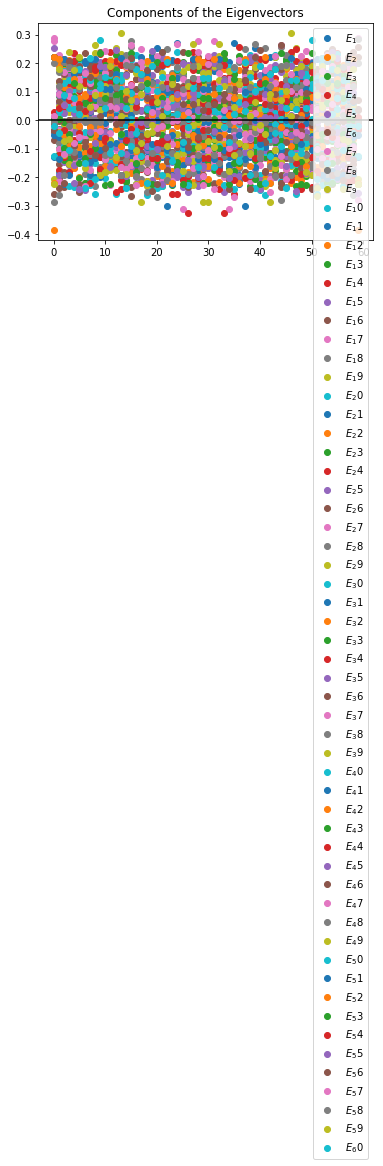

In [91]:
# Plot eigenvectors

for i in range(N):
    plt.plot(evecs[:,i],'o',label=r"$E_"+str(i+1)+"$")

plt.axhline(0,color='k')
plt.title("Components of the Eigenvectors")
plt.legend()
plt.show()

In [92]:
# Delocalization energy
# energy difference from ground state and isolated double bonds (compare to ethylene)
# Butadiene - 0.472
# Benzene - 2.0
# Toluene - 2.7206
# Naphthalene - 3.6832
# Buckyball - 33.1622

# determine delocalization energy, given total ground state energy and number of double bonds
def calcDeloc(E,numDB):
    Ne_ethy = 2
    evals_ethy = getEigs(ethy)[0]
    E_ethy = energyLevel(evals_ethy,Ne_ethy,name)[0]
    ETot_ethy = np.sum(E_ethy)
    deloc = numDB*ETot_ethy - ETot

    return deloc

deloc = calcDeloc(ETot,db)

print(str(deloc)+"b")

33.1622b


In [93]:
# Charge density estimation 
# for single electron in orbital I, |c_Ir|^2 is probability of electron being on atom r
# Butadiene - all 1
# Benzene - 
# Toluene - all 1
# Naphthalene - all 1
# Buckyball - all 1 

def chargeDensity(evecs,energies,occu):
    q = np.zeros(N)
        
    for r in range(N):
        c = evecs[r,:] # get the rth component of all eigenvectors
        cSq = np.square(c)
        q[r] = np.dot(cSq,occu)
    
    return q

q = chargeDensity(evecs,energies,occu)

print(q)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.]


In [94]:
# Bond order calculation
# Butadiene - 0.894 0.447 0.894
# Benzene - 0.667 0.667 0.667 0.667 0.667 0.667 
# Toluene - 0.635 0.523 0.705 0.635 0.635 0.705
# Naphthalene - 0.725 0.555 0.603 0.725 0.555 0.555 0.518 0.725 0.603 0.725 0.555
# Buckyball - 

# Verification with known values:
# Butadiene - http://www.faculty.umassd.edu/michele.mandrioli/424book/fchm8.8.html
# Benzene - ocw.mit.edu/courses/chemistry/5-61-physical-chemistry-fall-2007/lecture-notes/lecture31.pdf
# Toluene - 
# Naphthalene - 
# Buckyball - 

def bondOrder(adj,evecs,energies,occu):
    adjUp = np.triu(adj) # remove redundant elements
    r,s = np.nonzero(adjUp) # get indices of nonzero elements
    p = np.zeros(r.size)
    
    for i in range(r.size):
        cr = evecs[r[i],:]
        cs = evecs[s[i],:]
                
        cPr = np.multiply(cr,cs)
                
        p[i] = np.dot(cPr,occu)
    
    return p
    
p = bondOrder(adj,evecs,energies,occu)

print(p)

[ 0.476  0.476  0.601  0.476  0.601  0.476  0.601  0.476  0.601  0.601
  0.476  0.476  0.476  0.601  0.476  0.601  0.476  0.601  0.601  0.476
  0.476  0.476  0.476  0.601  0.476  0.601  0.601  0.476  0.476  0.476
  0.476  0.601  0.476  0.601  0.601  0.476  0.476  0.476  0.476  0.601
  0.476  0.601  0.601  0.476  0.476  0.476  0.476  0.601  0.476  0.601
  0.476  0.476  0.601  0.476  0.476  0.476  0.601  0.601  0.476  0.476
  0.476  0.476  0.476  0.601  0.601  0.476  0.476  0.476  0.476  0.476
  0.601  0.601  0.476  0.476  0.476  0.476  0.476  0.601  0.601  0.476
  0.476  0.476  0.476  0.476  0.601  0.476  0.476  0.476  0.476  0.476]


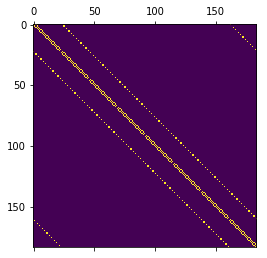

In [109]:
# Part B
# Construct adjacency matrix for graphene

# maps an (i,j) index from the square grid to the number of the atom at that location
def indexFind(i,j,rows,cols):
    i = i%cols
    j = j%rows
    return j*cols + i

# adds connection to adjacency matrix given 2 connected carbon atoms
def connect(n1,n2,adjMat):
    adjMat[n1,n2] = 1
    return

#
def constructZigzag(rows,cols):
    adjMat = np.zeros([rows*cols,rows*cols])
    
    for i in range(cols):
        for j in range(rows):
            cur = indexFind(i,j,rows,cols)
            
            connect(cur,indexFind(i+1,j,rows,cols),adjMat)
            connect(cur,indexFind(i-1,j,rows,cols),adjMat)
            
            if i%2 == j%2 and j != rows-1: 
                connect(cur,indexFind(i,j+1,rows,cols),adjMat)
            elif i%2 != j%2 and j != 0:
                connect(cur,indexFind(i,j-1,rows,cols),adjMat)    
    
    return adjMat

#
def constructArmchair(rows,cols):
    adjMat = np.zeros([rows*cols,rows*cols])
    
    for i in range(cols):
        for j in range(rows):
            cur = indexFind(i,j,rows,cols)
            
            if i != cols-1:
                connect(cur,indexFind(i+1,j,rows,cols),adjMat)
            if i != 0:
                connect(cur,indexFind(i-1,j,rows,cols),adjMat)
         
            if i%2 == j%2:
                connect(cur,indexFind(i,j+1,rows,cols),adjMat)
            else:
                connect(cur,indexFind(i,j-1,rows,cols),adjMat)    
        
    return adjMat

# 
def constructAdj(rows,cols): 
    if rows > cols:
        adjMat = constructZigzag(rows,cols)
    else:
        adjMat = constructArmchair(rows,cols)
    return adjMat

zig = 7  # layers of hexagons connected on flat edge
arm = 11 # layers of hexagons connected in "armchair" pattern
name = "graphene"+str(zig)+"x"+str(arm)

# for zigzag configuration, use arm > zig
# for armchair configuration, use zig > arm

# Consider square lattice from "stretched" hex lattice
rows = zig+1  # number of rows in "stretched" square lattice
cols = arm*2 + 1  # number of columns in "stretched" square lattice

Nc = rows*cols # total number of carbon atoms
Ne = Nc # total number of pi electrons

graph = constructAdj(rows,cols) 

plt.matshow(graph)
plt.show()

In [118]:
# Calculate eigenvalues/eigenvectors of graphene

evalsGraph,evecsGraph = getEigs(graph)
energies,occu = energyLevel(evalsGraph,Ne,name)

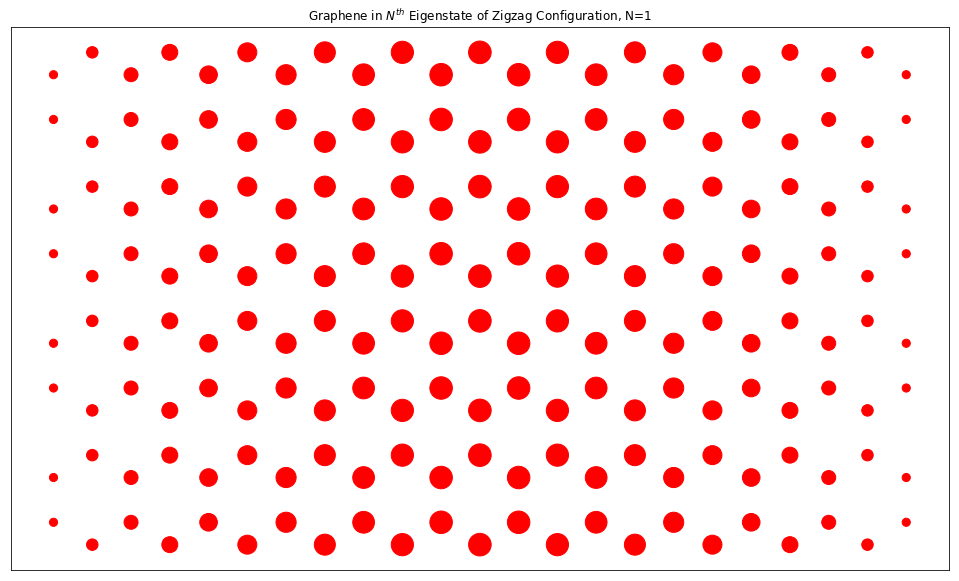

In [120]:
# drawing graphene lattice

# generate list of coordinates for each carbon
def getCoords(rows,cols):
    coords = np.zeros([rows*cols,2])
    bl = 1 # arbitrary bond length
    phi = np.pi / 6 # 
    dx = bl*np.cos(phi) # increment in x direction along a row
    dy = bl*np.sin(phi) # alternating +/- increment in y direction along each row
    
    # for even row j, initial y, y0_j = y0_j-1 - (bl + 2*dy)
    # for odd row j, initial y, y0_j = y0_j-1 - bl
    # dy follows the pattern: 
    #     if i%2 == j%2 -> +dy
    #     if i%2 != j%2 -> -dy
    
    for j in range(rows):
        x = 0 # each row starts at x=0
        y = coords[indexFind(0,j-1,rows,cols),1] - bl 
        
        if j%2 == 0: # for evens rows, increment by extra 2*dy
            y -= 2*dy
                
        for i in range(cols):
            cur = indexFind(i,j,rows,cols)
            coords[cur,0] = x
            coords[cur,1] = y
            
            x += dx
            if i%2 == j%2:
                y += dy
            else:
                y -= dy

    return coords


# set colors for plotting
# color p for positive, color n for negative
def getColors(v,p,n):
    colors = []
    for i in range(v.size):
        if v[i] > 0:
            colors.append(p)
        else:
            colors.append(n)
    return colors


coords = getCoords(rows,cols)
level = 1 # select energy level
weights = 5000*np.abs(evecsGraph[:,level-1])

p = 'b' # color mapped to positive values
n = 'r' # color mapped to negative values
colors = getColors(evecsGraph[:,level-1],p,n)

plt.figure(figsize=(20,10))

if zig < arm: # zigzag configuration
    plt.scatter(coords[:,0],coords[:,1],s=weights,c=colors)
    config = "Zigzag"
else: # armchair configuration
    plt.scatter(coords[:,1],coords[:,0],s=weights,c=colors)
    config = "Armchair"
    
plt.axes().set_aspect('equal')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.title(r"Graphene in $N^{th}$ Eigenstate of "+config+" Configuration, N="+str(level))
plt.savefig("figures/"+name+"N="+str(level)+".png")
plt.show()